# TensorFlow Regression Example

## Creating Data with 1 million points

In [1]:
import tensorflow as tf
tf.__version__

'1.3.0'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 1 Million Points spaced between 0 and 10
x_data = np.linspace(0.0,10.0,1000000)

In [4]:
noise = np.random.randn(len(x_data))

In [5]:
# y = mx + b + noise_levels
m_true=0.5
b_true = 5

y_true =  (m_true * x_data ) + b_true + noise

### Create a DataFrame with the data

In [6]:
my_data = pd.concat([pd.DataFrame(data=x_data,columns=['X Data']),pd.DataFrame(data=y_true,columns=['Y'])],axis=1)

In [7]:
my_data.head()

,X Data,Y
0,0.00000,6.312860
1,0.00001,5.276235
2,0.00002,4.382806
3,0.00003,4.195287
4,0.00004,6.989212


### Sample 250 random points and plot (not the entire dataset because that will take too much time)

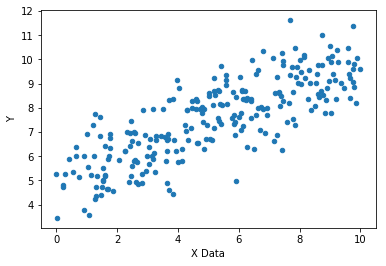

In [8]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')

# TensorFlow
## Batch Size

We will take the data in batches (1,000,000 points is a lot to pass in at once)

In [9]:
# Random 10 points to grab per batch
batch_size = 4

#### Start with any random slope and intercept

In [10]:
m = tf.Variable(0.8)
b = tf.Variable(1.0)

#### Placeholders

In [11]:
xph = tf.placeholder(tf.float32,[batch_size])
yph = tf.placeholder(tf.float32,[batch_size])

#### Graph

In [12]:
y_model = m*xph + b

#### Loss Function

In [13]:
error = tf.reduce_sum(tf.square(yph-y_model))

#### Optimizer

In [14]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(error)

#### Initialize Variables

In [15]:
init = tf.global_variables_initializer()

### Session (with just first batch)

In [16]:
with tf.Session() as sess:
    
    sess.run(init)
    
    batches = 1
    
    for i in range(batches):
        # Note the random indexing. A sequential indexing will not work very well.
        rand_ind = np.random.randint(len(x_data),size=batch_size)
        
        feed = {xph:x_data[rand_ind],yph:y_true[rand_ind]}
        
        sess.run(train,feed_dict=feed)
        
    model_m,model_b = sess.run([m,b])

In [17]:
print ("Model slope after just one batch of data:",model_m)
print ("Model intecept after just one batch of data:",model_b)

Model slope after just one batch of data: 0.822078
Model intecept after just one batch of data: 1.02919


### Results (not a good fit yet)

In [18]:
y_hat = x_data * model_m + model_b

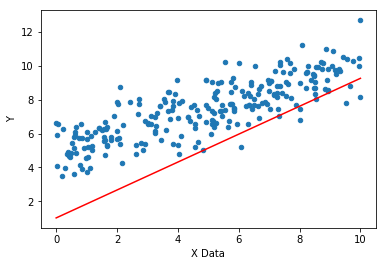

In [19]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(x_data,y_hat,'r')

### Increase the number of batches and plot the result
#### Note that the model slope (*m*) and model intercept (*b*) will be much close to their ground truth value of 0.5 and 5 respectively, and the linear fit will look better

Model m (slope) 0.554282
Model intercept 4.92731


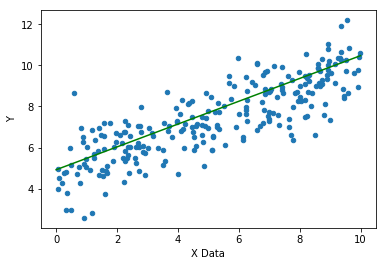

In [20]:
with tf.Session() as sess:
    
    sess.run(init)
    
    batches = 2000
    
    for i in range(batches):
        # Note the random indexing. A sequential indexing will not work very well.
        rand_ind = np.random.randint(len(x_data),size=batch_size)
        
        feed = {xph:x_data[rand_ind],yph:y_true[rand_ind]}
        
        sess.run(train,feed_dict=feed)
        
    model_m,model_b = sess.run([m,b])

print ("Model m (slope)", model_m)
print ("Model intercept", model_b)
y_hat = x_data * model_m + model_b
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(x_data,y_hat,'g')

## tf.estimator API

#### Much simpler API for basic tasks like regression!

### Define a feature column and the estimator object containing it (ignore any warning message)

In [21]:
feat_cols = [tf.feature_column.numeric_column('x',shape=[1])]

In [22]:
estimator = tf.estimator.LinearRegressor(feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Tirtha\\AppData\\Local\\Temp\\tmpf3v1k80p', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


### Train/Test Split using scikit-learn

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
x_train, x_eval, y_train, y_eval = train_test_split(x_data,y_true,test_size=0.3, random_state = 101)

In [25]:
print(x_train.shape)
print(y_train.shape)

print(x_eval.shape)
print(y_eval.shape)

(700000,)
(700000,)
(300000,)
(300000,)


### Set up Estimator Inputs

In [26]:
# Can also do .pandas_input_fn
input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=None,shuffle=True)

In [27]:
train_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=1000,shuffle=False)

In [28]:
eval_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_eval},y_eval,batch_size=4,num_epochs=1000,shuffle=False)

### Train the Estimator with small number of steps (say 10)

In [29]:
estimator.train(input_fn=input_func,steps=10)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Tirtha\AppData\Local\Temp\tmpf3v1k80p\model.ckpt.
INFO:tensorflow:loss = 216.131, step = 1
INFO:tensorflow:Saving checkpoints for 10 into C:\Users\Tirtha\AppData\Local\Temp\tmpf3v1k80p\model.ckpt.
INFO:tensorflow:Loss for final step: 41.6071.


### Evaluation

#### First, evaluate the estimator object on the training set

In [30]:
train_metrics = estimator.evaluate(input_fn=train_input_func,steps=1000)

INFO:tensorflow:Starting evaluation at 2017-11-04-22:15:11
INFO:tensorflow:Restoring parameters from C:\Users\Tirtha\AppData\Local\Temp\tmpf3v1k80p\model.ckpt-10
INFO:tensorflow:Evaluation [1/1000]
INFO:tensorflow:Evaluation [2/1000]
INFO:tensorflow:Evaluation [3/1000]
INFO:tensorflow:Evaluation [4/1000]
INFO:tensorflow:Evaluation [5/1000]
INFO:tensorflow:Evaluation [6/1000]
INFO:tensorflow:Evaluation [7/1000]
INFO:tensorflow:Evaluation [8/1000]
INFO:tensorflow:Evaluation [9/1000]
INFO:tensorflow:Evaluation [10/1000]
INFO:tensorflow:Evaluation [11/1000]
INFO:tensorflow:Evaluation [12/1000]
INFO:tensorflow:Evaluation [13/1000]
INFO:tensorflow:Evaluation [14/1000]
INFO:tensorflow:Evaluation [15/1000]
INFO:tensorflow:Evaluation [16/1000]
INFO:tensorflow:Evaluation [17/1000]
INFO:tensorflow:Evaluation [18/1000]
INFO:tensorflow:Evaluation [19/1000]
INFO:tensorflow:Evaluation [20/1000]
INFO:tensorflow:Evaluation [21/1000]
INFO:tensorflow:Evaluation [22/1000]
INFO:tensorflow:Evaluation [23/10

#### After that, evaluate the estimator on the test/evaluation set

In [31]:
eval_metrics = estimator.evaluate(input_fn=eval_input_func,steps=1000)

INFO:tensorflow:Starting evaluation at 2017-11-04-22:15:16
INFO:tensorflow:Restoring parameters from C:\Users\Tirtha\AppData\Local\Temp\tmpf3v1k80p\model.ckpt-10
INFO:tensorflow:Evaluation [1/1000]
INFO:tensorflow:Evaluation [2/1000]
INFO:tensorflow:Evaluation [3/1000]
INFO:tensorflow:Evaluation [4/1000]
INFO:tensorflow:Evaluation [5/1000]
INFO:tensorflow:Evaluation [6/1000]
INFO:tensorflow:Evaluation [7/1000]
INFO:tensorflow:Evaluation [8/1000]
INFO:tensorflow:Evaluation [9/1000]
INFO:tensorflow:Evaluation [10/1000]
INFO:tensorflow:Evaluation [11/1000]
INFO:tensorflow:Evaluation [12/1000]
INFO:tensorflow:Evaluation [13/1000]
INFO:tensorflow:Evaluation [14/1000]
INFO:tensorflow:Evaluation [15/1000]
INFO:tensorflow:Evaluation [16/1000]
INFO:tensorflow:Evaluation [17/1000]
INFO:tensorflow:Evaluation [18/1000]
INFO:tensorflow:Evaluation [19/1000]
INFO:tensorflow:Evaluation [20/1000]
INFO:tensorflow:Evaluation [21/1000]
INFO:tensorflow:Evaluation [22/1000]
INFO:tensorflow:Evaluation [23/10

#### Print the evaluated metrices to check the final loss function values
#### Test and train set losses should be close, with test loss being slightly higher
#### If that is not the case, then either underfitting (high bias) or overfitting (high variance) is occuring

In [32]:
print("train metrics: {}".format(train_metrics))
print("eval metrics: {}".format(eval_metrics))

train metrics: {'average_loss': 9.871089, 'loss': 39.484356, 'global_step': 10}
eval metrics: {'average_loss': 10.316621, 'loss': 41.266483, 'global_step': 10}


### Predictions and plotting the fitted line

In [33]:
input_fn_predict = tf.estimator.inputs.numpy_input_fn({'x':np.linspace(0,10,10)},shuffle=False)

In [34]:
list(estimator.predict(input_fn=input_fn_predict))

INFO:tensorflow:Restoring parameters from C:\Users\Tirtha\AppData\Local\Temp\tmpf3v1k80p\model.ckpt-10


[{'predictions': array([ 0.78866887], dtype=float32)},
 {'predictions': array([ 1.63075137], dtype=float32)},
 {'predictions': array([ 2.47283411], dtype=float32)},
 {'predictions': array([ 3.31491637], dtype=float32)},
 {'predictions': array([ 4.15699911], dtype=float32)},
 {'predictions': array([ 4.99908161], dtype=float32)},
 {'predictions': array([ 5.84116364], dtype=float32)},
 {'predictions': array([ 6.68324661], dtype=float32)},
 {'predictions': array([ 7.52532959], dtype=float32)},
 {'predictions': array([ 8.36741161], dtype=float32)}]

In [35]:
predictions = []# np.array([])
for x in estimator.predict(input_fn=input_fn_predict):
    predictions.append(x['predictions'])

INFO:tensorflow:Restoring parameters from C:\Users\Tirtha\AppData\Local\Temp\tmpf3v1k80p\model.ckpt-10


In [36]:
predictions

[array([ 0.78866887], dtype=float32),
 array([ 1.63075137], dtype=float32),
 array([ 2.47283411], dtype=float32),
 array([ 3.31491637], dtype=float32),
 array([ 4.15699911], dtype=float32),
 array([ 4.99908161], dtype=float32),
 array([ 5.84116364], dtype=float32),
 array([ 6.68324661], dtype=float32),
 array([ 7.52532959], dtype=float32),
 array([ 8.36741161], dtype=float32)]

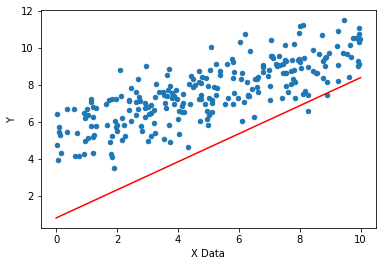

In [37]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(np.linspace(0,10,10),predictions,'r')

### Now train the estimator with large number of steps and see the difference

In [38]:
estimator.train(input_fn=input_func,steps=1000)

predictions = []
for x in estimator.predict(input_fn=input_fn_predict):
    predictions.append(x['predictions'])

train_metrics = estimator.evaluate(input_fn=train_input_func,steps=1000)
eval_metrics = estimator.evaluate(input_fn=eval_input_func,steps=1000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Tirtha\AppData\Local\Temp\tmpf3v1k80p\model.ckpt-10
INFO:tensorflow:Saving checkpoints for 11 into C:\Users\Tirtha\AppData\Local\Temp\tmpf3v1k80p\model.ckpt.
INFO:tensorflow:loss = 30.4487, step = 11
INFO:tensorflow:global_step/sec: 711.118
INFO:tensorflow:loss = 13.6784, step = 111 (0.141 sec)
INFO:tensorflow:global_step/sec: 914.15
INFO:tensorflow:loss = 19.8772, step = 211 (0.109 sec)
INFO:tensorflow:global_step/sec: 914.399
INFO:tensorflow:loss = 5.16559, step = 311 (0.109 sec)
INFO:tensorflow:global_step/sec: 1066.66
INFO:tensorflow:loss = 15.8487, step = 411 (0.094 sec)
INFO:tensorflow:global_step/sec: 914.274
INFO:tensorflow:loss = 3.37689, step = 511 (0.109 sec)
INFO:tensorflow:global_step/sec: 1066.65
INFO:tensorflow:loss = 11.0442, step = 611 (0.094 sec)
INFO:tensorflow:global_step/sec: 1066.66
INFO:tensorflow:loss = 1.85639, step = 711 (0.094 sec)
INFO:tensorflow:global_step/sec: 9

train metrics: {'average_loss': 1.1024081, 'loss': 4.4096322, 'global_step': 1010}
eval metrics: {'average_loss': 1.1659117, 'loss': 4.6636467, 'global_step': 1010}


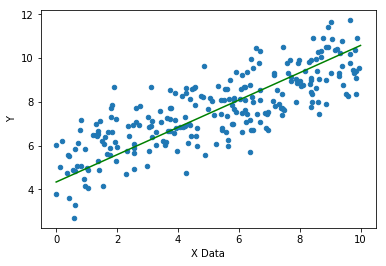

In [39]:
print("train metrics: {}".format(train_metrics))
print("eval metrics: {}".format(eval_metrics))
    
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(np.linspace(0,10,10),predictions,'g')